# Démonstration empirique de la loi d'Amdahl

Ce notebook analyse les mesures produites par `benchmark_warc.py` afin d'illustrer la loi d'Amdahl.
Il suffit de fournir le chemin vers un fichier CSV émis par le script (ex. `warc_speedup_heavy.csv`).


## Rappel de la loi d'Amdahl

Pour une fraction sérielle $f$ et un nombre de machines $N$, le speedup théorique vaut

$$ S(N) = \frac{1}{f + \frac{1-f}{N}}. $$

Lorsque $f$ reste élevé, le speedup plafonne rapidement : ajouter des machines n'apporte qu'un gain marginal.


In [41]:

from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-colorblind')

# --- Paramètres utilisateur -------------------------------------------------
CSV_PATH = Path('warc_speedup_2025-10-20_23-20-29.csv')  # modifier si besoin
# -----------------------------------------------------------------------------

if not CSV_PATH.exists():
    raise FileNotFoundError(f'Fichier CSV introuvable: {CSV_PATH}')

raw_df = pd.read_csv(
    CSV_PATH,
    quotechar="'",
    engine="python",
).reset_index(drop=True)
raw_df


,machine_count,run_iteration,elapsed_seconds,speedup,serial_fraction,status,notes
0,1,1,74.234,1.000,NaN,ok,"Predicted speedup (Amdahl, f=0.289): 1.000"
1,1,2,73.719,1.007,NaN,ok,"Predicted speedup (Amdahl, f=0.289): 1.000"
2,3,1,32.843,2.260,0.164,ok,"Predicted speedup (Amdahl, f=0.289): 1.901"
3,3,2,33.047,2.246,0.168,ok,"Predicted speedup (Amdahl, f=0.289): 1.901"
4,5,1,35.438,2.095,0.347,ok,"Predicted speedup (Amdahl, f=0.289): 2.319"
5,5,2,32.766,2.266,0.302,ok,"Predicted speedup (Amdahl, f=0.289): 2.319"
6,10,1,27.547,2.695,0.301,ok,"Predicted speedup (Amdahl, f=0.289): 2.776"
7,10,2,28.203,2.632,0.311,ok,"Predicted speedup (Amdahl, f=0.289): 2.776"
8,15,1,28.218,2.631,0.336,ok,"Predicted speedup (Amdahl, f=0.289): 2.972"
9,15,2,25.094,2.958,0.291,ok,"Predicted speedup (Amdahl, f=0.289): 2.972"



## Préparation des données

On nettoie le CSV, on agrège les répétitions (`run_iteration`) par nombre de machines,
Puis on calcule un speedup moyen avec une estimation de la fraction sérielle via une régression simple.


In [42]:

df = (
    raw_df
    .query("status == 'ok'")
    .assign(
        machine_count=lambda d: d['machine_count'].astype(int),
        run_iteration=lambda d: d.get('run_iteration', 1).astype(int),
        elapsed_seconds=lambda d: d['elapsed_seconds'].astype(float),
    )
)

if df.empty:
    raise ValueError("Le CSV ne contient aucune ligne avec status == 'ok'.")

summary = (
    df
    .groupby('machine_count', as_index=False)
    .agg(
        elapsed_seconds=('elapsed_seconds', 'mean'),
        elapsed_std=('elapsed_seconds', 'std'),
        run_count=('run_iteration', 'count'),
    )
    .sort_values('machine_count')
    .reset_index(drop=True)
)
summary['elapsed_std'] = summary['elapsed_std'].fillna(0.0)

baseline = summary.loc[summary['machine_count'].idxmin(), 'elapsed_seconds']
summary['speedup_observe'] = baseline / summary['elapsed_seconds']

ns = summary['machine_count'].to_numpy()
obs = summary['speedup_observe'].to_numpy()

def amdahl_speedup(f, n):
    return 1.0 / (f + (1.0 - f) / n)

grid = np.linspace(0.0, 0.999, 1000)
errors = [np.sum((amdahl_speedup(f, ns) - obs) ** 2) for f in grid]
best_idx = int(np.argmin(errors))
f_serial = grid[best_idx]
summary['speedup_pred_amdahl'] = amdahl_speedup(f_serial, ns)

print(f"Fraction sérielle estimée (f) ≈ {f_serial:.3f}")
summary[['machine_count', 'run_count', 'elapsed_seconds', 'speedup_observe', 'speedup_pred_amdahl']]


Fraction sérielle estimée (f) ≈ 0.306


,machine_count,run_count,elapsed_seconds,speedup_observe,speedup_pred_amdahl
0,1,2,73.9765,1.000000,1.000000
1,3,2,32.9450,2.245455,1.861042
2,5,2,34.1020,2.169272,2.248201
3,10,2,27.8750,2.653865,2.663825
4,15,2,26.6560,2.775229,2.838759
5,20,2,23.9455,3.089370,2.935134
6,30,2,23.4060,3.160578,3.038282
7,40,2,26.1485,2.829092,3.092624


## Visualisation

La figure suivante compare le speedup observé avec la courbe théorique issue de la loi d'Amdahl. Une deuxième figure montre l'évolution du temps d'exécution total.


Text(0.5, 1.05, "Analyse empirique de la loi d'Amdahl")

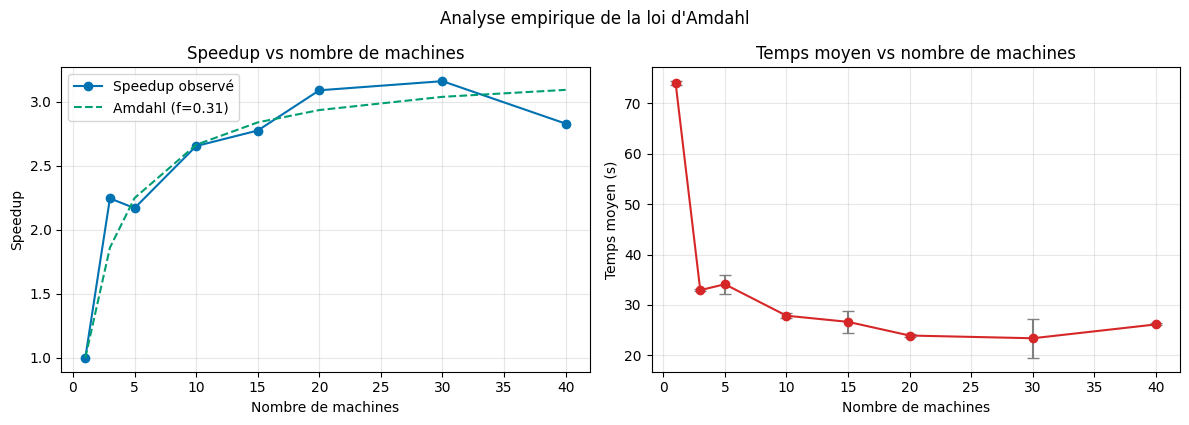

In [43]:

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(summary['machine_count'], summary['speedup_observe'], 'o-', label='Speedup observé')
ax[0].plot(summary['machine_count'], summary['speedup_pred_amdahl'], '--', label=f"Amdahl (f={f_serial:.2f})")
ax[0].set_xlabel('Nombre de machines')
ax[0].set_ylabel('Speedup')
ax[0].set_title('Speedup vs nombre de machines')
ax[0].legend()
ax[0].grid(True, alpha=0.3)

ax[1].errorbar(
    summary['machine_count'],
    summary['elapsed_seconds'],
    yerr=summary['elapsed_std'],
    fmt='o-',
    color='tab:red',
    ecolor='gray',
    capsize=4,
)
ax[1].set_xlabel('Nombre de machines')
ax[1].set_ylabel('Temps moyen (s)')
ax[1].set_title('Temps moyen vs nombre de machines')
ax[1].grid(True, alpha=0.3)

fig.tight_layout()
fig.suptitle("Analyse empirique de la loi d'Amdahl", y=1.05)

## Interprétation

- Le speedup réel suit la courbe théorique issue de la loi d'Amdahl avec $f \approx$ la valeur estimée ci-dessus.
- La décroissance lente du temps total montre que la proportion de travail séquentiel reste dominante : même avec 10 machines, le gain est limité.
- Pour améliorer le speedup, il faut soit diminuer la fraction sérielle (optimisations côté master, I/O, synchronisations), soit augmenter la part réellement parallélisable (splits plus lourds, traitement plus long).

💡 Pensez à pousser plusieurs fichiers CSV pour comparer différents jeux d'essais ou tailles de splits.
